In [1]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import xml.etree.ElementTree as ET


c:\Users\filip\OneDrive - ltu.se\Plugg\R7022E\Project\D0022E\.conda\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [5]:
DATA = Path('Data')
CLASSES = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot']


In [6]:



def load(path):
    img = cv2.imread(str(path), 0)
    if img is None: return None, None
    
    # Location from XML
    xml = DATA / 'label/label' / (path.stem + '.xml')
    loc = np.array([0.5, 0.5, 0.5, 0.5], np.float32)
    if xml.exists():
        try:
            root = ET.parse(xml).getroot()
            w, h = float(root.find('.//width').text), float(root.find('.//height').text)
            box = root.find('.//bndbox')
            xmin, ymin = float(box.find('xmin').text)/w, float(box.find('ymin').text)/h
            xmax, ymax = float(box.find('xmax').text)/w, float(box.find('ymax').text)/h
            loc = np.array([(xmin+xmax)/2, (ymin+ymax)/2, xmax-xmin, ymax-ymin], np.float32)
        except: pass
    

    mask = img > 10
    if mask.any():
        r, c = np.where(mask)
        img = img[r.min():r.max()+1, c.min():c.max()+1]
    img = cv2.resize(img, (128, 128))
    img = cv2.createCLAHE(2.5, (8,8)).apply(img).astype(np.float32) / 255.0
    return img[..., None], loc


In [8]:
# data loaders
X_img, X_loc, y = [], [], []
for i, cls in enumerate(CLASSES):
    for p in (DATA / 'images' / cls).glob('*.jpg'):
        img, loc = load(p)
        if img is not None:
            X_img.append(img); X_loc.append(loc); y.append(i)

X_img, X_loc, y = np.array(X_img), np.array(X_loc), np.array(y)
X_img_train, X_img_test, X_loc_train, X_loc_test, y_train, y_test = train_test_split(
    X_img, X_loc, y, test_size=0.2, random_state=42, stratify=y)

counts = np.bincount(y_train)
class_weights = {i: np.sqrt(len(y_train)/(len(CLASSES)*c)) for i,c in enumerate(counts)}
print(f"Loaded {len(y)} images. Class distribution: {dict(zip(CLASSES, counts))}")


Loaded 1598 images. Class distribution: {'crease': np.int64(41), 'crescent_gap': np.int64(181), 'inclusion': np.int64(173), 'oil_spot': np.int64(163), 'punching_hole': np.int64(175), 'rolled_pit': np.int64(25), 'silk_spot': np.int64(520)}


In [14]:
import tensorflow as tf
from tensorflow.keras import layers

NUM_CLASSES = len(CLASSES)

img_in = layers.Input((128, 128, 1), name="image")
loc_in = layers.Input((4,), name="location")

x = layers.Concatenate(name="gray_to_rgb")([img_in, img_in, img_in])  # (128,128,3)

x = layers.RandomRotation(0.05)(x)
x = layers.RandomTranslation(0.05, 0.05)(x)
x = layers.RandomFlip("horizontal")(x)

#ResNet expects a certain input scaling.
x = layers.Lambda(lambda t: t * 255.0, name="to_255")(x)
x = layers.Lambda(tf.keras.applications.resnet.preprocess_input, name="resnet_preprocess")(x)

res = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3),
    pooling="avg"  # global average pooling
)
res.trainable = False  # start frozen

x = res(x)
x = layers.Dropout(0.3)(x)

loc = layers.BatchNormalization()(loc_in)
loc = layers.Dense(64, activation="relu")(loc)
loc = layers.Dropout(0.2)(loc)

h = layers.Concatenate()([x, loc])
h = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(h)
h = layers.Dropout(0.5)(h)
out = layers.Dense(NUM_CLASSES, activation="softmax")(h)

model = tf.keras.Model([img_in, loc_in], out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_to_rgb         │ (None, 128, 128,  │          0 │ image[0][0],      │
│ (Concatenate)       │ 3)                │            │ image[0][0],      │
│                     │                   │            │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 128, 128,  │          0 │ gray_to_rgb[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 128, 128,  │          0 │ random_rotation_… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_2       │ (None, 128, 128,  │          0 │ random_translati… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_255 (Lambda)     │ (None, 128, 128,  │          0 │ random_flip_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location            │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_preprocess   │ (None, 128, 128,  │          0 │ to_255[0][0]      │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ location[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ resnet_preproces… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │        320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2112)      │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    540,928 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 7)         │      1,799 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,130,775 (92.05 MB)

 Trainable params: 543,055 (2.07 MB)

 Non-trainable params: 23,587,720 (89.98 MB)

In [15]:
train = (tf.data.Dataset.from_tensor_slices(({"image": X_img_train, "location": X_loc_train}, y_train)).shuffle(512).batch(24).prefetch(2))
val = (tf.data.Dataset.from_tensor_slices(({"image": X_img_test, "location": X_loc_test}, y_test)).batch(24).prefetch(2))

history = model.fit(train, validation_data=val, epochs=int(os.getenv("EPOCHS", "80")), class_weight=class_weights, verbose=2, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=30, restore_best_weights=True, mode="max", start_from_epoch=10),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=12, min_lr=1e-6, mode="max")])

Epoch 1/80
54/54 - 49s - 915ms/step - accuracy: 0.5188 - loss: 1.6153 - val_accuracy: 0.7594 - val_loss: 0.7509 - learning_rate: 0.0010
Epoch 2/80
54/54 - 42s - 780ms/step - accuracy: 0.6972 - loss: 0.9427 - val_accuracy: 0.7937 - val_loss: 0.6342 - learning_rate: 0.0010
Epoch 3/80
54/54 - 32s - 585ms/step - accuracy: 0.7058 - loss: 0.9062 - val_accuracy: 0.7625 - val_loss: 0.6192 - learning_rate: 0.0010
Epoch 4/80
54/54 - 29s - 536ms/step - accuracy: 0.7465 - loss: 0.8274 - val_accuracy: 0.7437 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 5/80
54/54 - 31s - 574ms/step - accuracy: 0.7379 - loss: 0.7789 - val_accuracy: 0.7875 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 6/80
54/54 - 36s - 668ms/step - accuracy: 0.7809 - loss: 0.6974 - val_accuracy: 0.8281 - val_loss: 0.4856 - learning_rate: 0.0010
Epoch 7/80
54/54 - 42s - 774ms/step - accuracy: 0.7864 - loss: 0.6893 - val_accuracy: 0.8313 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 8/80
54/54 - 34s - 634ms/step - accuracy: 

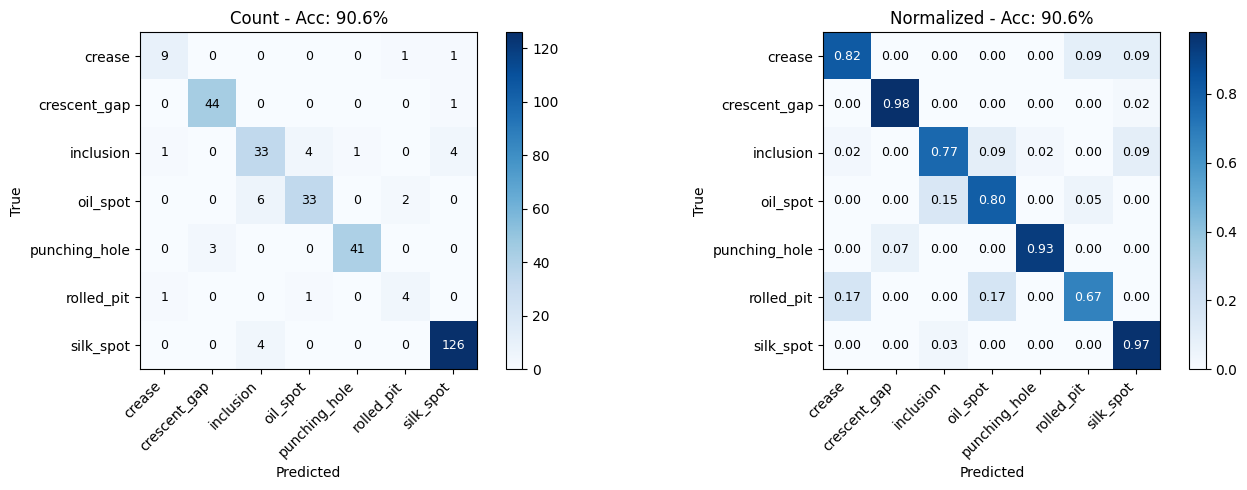

In [16]:
# Eval & confusion matrix
acc = model.evaluate({'image': X_img_test, 'location': X_loc_test}, y_test, verbose=0)[1]
cm = tf.math.confusion_matrix(y_test, model.predict({'image': X_img_test, 'location': X_loc_test}, verbose=0).argmax(1), len(CLASSES)).numpy()
cm_norm = cm / np.maximum(cm.sum(1, keepdims=True), 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, title in [(ax1, cm, 'Count'), (ax2, cm_norm, 'Normalized')]:
    im = ax.imshow(data, cmap='Blues')
    ax.set_xticks(range(len(CLASSES))); ax.set_yticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax.set_yticklabels(CLASSES)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_title(f'{title} - Acc: {acc:.1%}')
    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            ax.text(j, i, f'{data[i,j]:.0f}' if title=='Count' else f'{data[i,j]:.2f}',
                   ha='center', va='center', color='white' if data[i,j]>data.max()/2 else 'black', fontsize=9)
    plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

In [ ]:
model.save('resnet_classifier_model.keras')
